# **Preprocessing**

In [ ]:
from osgeo import gdal
import numpy as np
import os

In [ ]:
from google.colab import drive  # Importing Google Colab's drive module for mounting Google Drive
drive.mount('/content/drive')  # Mounting the Google Drive to the '/content/drive' directory

Mounted at /content/drive


In [ ]:
# Specify the path to the main folder containing class folders in Google Drive
folders_path = '/content/drive/MyDrive/Data/'

# List the class folders within the main folder
classes = os.listdir(folders_path)

# Create an empty dictionary to store class names and their corresponding numerical labels
dict_class = {}

# Iterate through the classes and assign a numerical label to each class
for i in range(len(classes)):
    # The numerical label is assigned as i+1 to start from 1
    dict_class.update({classes[i]: i + 1})

# Display the resulting dictionary
dict_class

{'PermanentCrop': 1,
 'River': 2,
 'Highway': 3,
 'Residential': 4,
 'SeaLake': 5,
 'Pasture': 6,
 'HerbaceousVegetation': 7,
 'AnnualCrop': 8,
 'Industrial': 9,
 'Forest': 10}

In [ ]:
# Define the total number of classes in your dataset
num_classes = 13

# Specify the number of patches
patch_numbers = 1000

# Define the size of each image patch (assuming it's a square)
patch_size = 64

# Specify the number of spectral bands in your satellite imagery
bands = 13

# Create empty arrays to store your input images (X) and corresponding labels (Y)
X = np.zeros((patch_numbers, patch_size, patch_size, bands), dtype='float32')
Y = np.zeros((patch_numbers, num_classes), dtype='float32')

In [ ]:
# Initialize a counter to keep track of the total number of patches processed
Counter = 0
# Iterate through each class in your dataset
for cls in classes:
    # Get a list of images in the current class folder
    image_list = os.listdir(folders_path + cls)

    # Iterate through each image in the current class
    for img in image_list:
        # Read the image using GDAL (assuming it's a raster image)
        image = gdal.Open(folders_path + cls + '/' + img).ReadAsArray()

        # Create an empty array to store the reshaped image with the desired patch size and bands
        new_image = np.zeros((patch_size, patch_size, bands), dtype='float32')

        # Iterate through each band in the original image
        for b in range(bands):
            # Copy the band to the corresponding slice in the new image
            new_image[:, :, b] = image[b, :, :]

        # Store the reshaped image in the X array
        X[Counter, :, :, :] = new_image

        # Determine the column (class label) for the current image and update the Y array
        column = dict_class[cls]
        Y[Counter, column - 1] = 1

        # Increment the counter
        Counter = Counter + 1

In [ ]:
print('X shape: ', X.shape)
print('Y shape: ', Y.shape)

X shape:  (1000, 64, 64, 13)
Y shape:  (1000, 13)


In [ ]:
# Create an array of indices ranging from 0 to the total number of patches
indexes = np.arange(X.shape[0])

# Shuffle the indices randomly to ensure randomness in train/validation split
np.random.shuffle(indexes)

# Determine the index for the split between training and validation sets (90%/10%)
train_index = indexes[: int(0.9 * X.shape[0])]
val_index = indexes[int(0.9 * X.shape[0]):]

# Use the indices to extract the corresponding patches for training and validation
x_train = X[train_index]
x_val = X[val_index]
y_train = Y[train_index]
y_val = Y[val_index]

# Print the shapes of the training and validation sets for verification
print('X Train shape: ', x_train.shape)
print('Y Train shape: ', y_train.shape)
print('X Validation shape: ', x_val.shape)
print('Y Validation shape: ', y_val.shape)

X Train shape:  (900, 64, 64, 13)
Y Train shape:  (900, 10)
X Validation shape:  (100, 64, 64, 13)
Y Validation shape:  (100, 10)


# **ViT Architecture**

In [ ]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),  # Normalizing input data
        layers.experimental.preprocessing.RandomFlip("horizontal"),  # Randomly flipping input horizontally
        layers.experimental.preprocessing.RandomRotation(factor=0.02),  # Randomly rotating input by a small factor
        layers.experimental.preprocessing.RandomContrast(0.04),  # Randomly adjusting contrast of input
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),  # Randomly zooming into or out of input
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(x_train)  # Adapting the normalization layer to the training data

In [ ]:
patch_size_in_vit = 8  # Size of patches for Vision Transformer (ViT)
image_size = 64  # Size of input images

def extract_patch(images):
    """
    Extracts patches from input images using TensorFlow's extract_patches function.

    Args:
        images: Input images with shape [batch_size, height, width, channels].

    Returns:
        patches: Extracted patches from input images with shape [batch_size, num_patches, patch_dims].
    """
    batch_size = tf.shape(images)[0]  # Getting batch size
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, patch_size_in_vit, patch_size_in_vit, 1],  # Patch size
        strides=[1, patch_size_in_vit, patch_size_in_vit, 1],  # Stride for patch extraction
        rates=[1, 1, 1, 1],
        padding="VALID",  # Padding mode
    )
    patch_dims = patches.shape[-1]  # Calculating patch dimensions
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])  # Reshaping patches
    return patches

In [ ]:
index = 0  # Index of the image in the training dataset
number_of_bands = 1  # Number of bands used in the image data

# Selecting a sample data from the training dataset with specified number of bands
sample_data = x_train[index:index+1, :, :, number_of_bands:number_of_bands+1]

# Extracting patches from the sample data
patches = extract_patch(sample_data)

# Printing information about image size, patch size, and patches per image
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size_in_vit} X {patch_size_in_vit}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

Image size: 64 X 64
Patch size: 8 X 8
Patches per image: 64
Elements per patch: 64


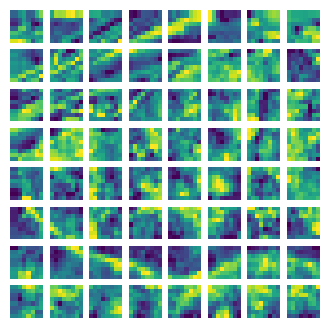

In [ ]:
# Visualizing the extracted patches
n = int(np.sqrt(patches.shape[1]))  # Number of patches to display in each dimension
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size_in_vit, patch_size_in_vit))
    plt.imshow(patch_img.numpy())  # Displaying the patch image
    plt.axis("off")  # Turning off axis

In [ ]:
image_size = 64  # Size of the input image
patch_size = 8  # Size of each patch
num_patches = (image_size // patch_size) ** 2  # Number of patches in the image
projection_dim = 128  # Dimensionality of the projected embeddings

def patch_encoder(patch, num_patches, projection_dim):
    """
    Encodes each patch using an embedding layer followed by a dense layer.

    Args:
        patch: Input patch data with shape [batch_size, patch_size, patch_size, channels].
        num_patches: Number of patches in the image.
        projection_dim: Dimensionality of the projected embeddings.

    Returns:
        encoded: Encoded representation of the patch with shape [batch_size, num_patches, projection_dim].
    """
    positions = tf.range(start=0, limit=num_patches, delta=1)  # Generating positional embeddings

    # Embedding layer for positional embeddings
    emd = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)

    # Dense layer for encoding the patch
    dens = layers.Dense(units=projection_dim)(patch)

    # Adding positional embeddings and patch encoding
    encoded = emd + dens

    return encoded


In [ ]:
transformer_units = [
  projection_dim * 2,
  projection_dim,
]  # Size of the transformer layers

def mlp(x, hidden_units, dropout=0.2):
    """
    Defines a Multi-Layer Perceptron (MLP) block.

    Args:
        x: Input tensor.
        hidden_units: List of integers specifying the number of units in each hidden layer.
        dropout: Dropout rate for the dropout layers.

    Returns:
        x: Output tensor after passing through the MLP block.
    """
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)  # Fully connected layer with GELU activation
        x = layers.Dropout(dropout)(x)  # Dropout layer
    return x

In [ ]:
number_of_heads=8
transformer_layers=8

def vit_model(input_shape):
  inputs=layers.Input(shape=input_shape)

  #Data Augmentation
  augmented_data=data_augmentation(inputs)

  # Extract patches from input image
  patches=extract_patch(augmented_data)

  #Patch Encoder
  Encoded_patches=patch_encoder(patches, num_patches, projection_dim)

  # print(Encoded_patches.shape)

  # Create a multiple transformer layer.
  for _ in range(transformer_layers):

    x1=layers.LayerNormalization(epsilon=1e-6)(Encoded_patches)
    # print(x1.shape)

    # Create a multi-head attention layer.
    attention_output=layers.MultiHeadAttention(
        num_heads=number_of_heads,
        key_dim=projection_dim,
        dropout=0.2
    )(x1,x1)
    # print(attention_output)

    # Create skip connection
    x2=layers.Add()([attention_output,Encoded_patches])
    # print(x2.shape)

    # Normalization layer
    x3=layers.LayerNormalization(epsilon=1e-6)(x2)
    # print(x3.shape)

    # MLP section
    x3=mlp(x3,hidden_units=transformer_units,dropout=0.1)

    # Skip connection
    Encoded_patches=layers.Add()([x3,x2])
    # print(Encoded_patches)

  # Create a [batch_size, projection_dim] tensor.
  representation = layers.LayerNormalization(epsilon=1e-6)(Encoded_patches)  # Layer normalization
  representation = layers.Flatten()(representation)  # Flatten the tensor
  representation = layers.Dropout(0.5)(representation)  # Dropout layer

  # Add MLP.
  features = mlp(representation, hidden_units=[2048, 1024], dropout=0.5)  # Apply MLP to the representation

  # Classify outputs.
  logits = layers.Dense(10, activation='softmax')(features)  # Dense layer with softmax activation for classification

  # Create the Keras model.
  model = keras.Model(inputs=inputs, outputs=logits)  # Define the model with input and output layers

  return model


In [ ]:
# Create an instance of the ViT model with input shape (64, 64, 13)
model = vit_model((64, 64, 13))

# Print the summary of the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 13)]         0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 64, 64, 13)           27        ['input_2[0][0]']             
 ial)                                                                                             
                                                                                                  
 tf.compat.v1.shape_1 (TFOp  (4,)                         0         ['data_augmentation[1][0]']   
 Lambda)                                                                                          
                                                                                            

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)  # Adam optimizer with specified learning rate

model.compile(
    optimizer=optimizer,  # Set the optimizer
    loss=keras.losses.CategoricalCrossentropy(),  # Categorical crossentropy loss function
    metrics=['accuracy'],  # Evaluation metric: accuracy
)

In [ ]:
history = model.fit(
    x_train,  # Training data
    y_train,  # Training labels
    epochs=100,  # Number of epochs
    validation_data=(x_val, y_val),  # Validation data and labels
)

Epoch 1/100
29/29 [==============================] - 34s 127ms/step - loss: 3.2300 - accuracy: 0.2511 - val_loss: 2.0016 - val_accuracy: 0.4500
Epoch 2/100
29/29 [==============================] - 2s 77ms/step - loss: 2.3814 - accuracy: 0.3611 - val_loss: 2.2655 - val_accuracy: 0.4500
Epoch 3/100
29/29 [==============================] - 2s 82ms/step - loss: 2.1140 - accuracy: 0.4200 - val_loss: 2.6755 - val_accuracy: 0.3800
Epoch 4/100
29/29 [==============================] - 3s 89ms/step - loss: 1.9119 - accuracy: 0.4400 - val_loss: 2.4977 - val_accuracy: 0.4400
Epoch 5/100
29/29 [==============================] - 2s 78ms/step - loss: 1.8210 - accuracy: 0.4833 - val_loss: 2.9681 - val_accuracy: 0.4300
Epoch 6/100
29/29 [==============================] - 2s 76ms/step - loss: 1.7629 - accuracy: 0.4789 - val_loss: 2.8338 - val_accuracy: 0.4300
Epoch 7/100
29/29 [==============================] - 2s 78ms/step - loss: 1.5097 - accuracy: 0.5333 - val_loss: 2.3504 - val_accuracy: 0.5200
Epoc

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomContrast(0.04),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(x_train)

In [ ]:
index=0
number_of_bands=1

sample_data=x_train[index:index+1,:,:,number_of_bands:number_of_bands+1]

patches = Ex_patches(sample_data)

print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size_in_vit} X {patch_size_in_vit}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

Image size: 64 X 64
Patch size: 8 X 8
Patches per image: 64
Elements per patch: 64


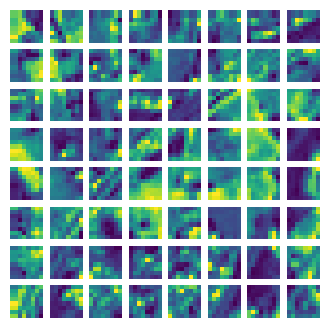

In [ ]:
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size_in_vit, patch_size_in_vit))
    plt.imshow(patch_img.numpy())
    plt.axis("off")